In [1]:
!pip install folium==0.5.0

In [2]:
!pip install geopy

In [3]:
import numpy as np
import pandas as pd
import folium
import requests
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup

In [4]:
#Scrapping planning area data from wikipedia

table = pd.read_html('https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore')
table = pd.DataFrame(table[2])
df = table.drop(['Malay','Chinese', 'Tamil','Pinyin','Region', 'Area (km2)'], axis = 1)
df.columns = ['Name', 'Population', 'Density']
for i in range(len(df.index)):
    if df.loc[i,'Population'] == '*':
        df.drop(i, axis = 0, inplace = True)
df.reset_index(drop=True,inplace =True)

# Adding latitude and longitude to data
geolocator = Nominatim(user_agent="foursquare_agent")

for i in range(len(df.index)):
    address = df['Name'][i] + ', Singapore'
    location = geolocator.geocode(address)
    df.loc[i,'latitude'] = location.latitude
    df.loc[i,'longitude'] = location.longitude
    
for index in df.index:
    if df.loc[index,'Name'] in ['North-Eastern Islands','Southern Islands', 'Western Islands']:
        df.drop(index, axis= 0, inplace = True)

df

,Name,Population,Density,latitude,longitude
0,Ang Mo Kio,163950,13400,1.370073,103.849516
1,Bedok,279380,13000,1.323976,103.930216
2,Bishan,88010,12000,1.350986,103.848255
3,Boon Lay,30,3.6,1.338575,103.705848
4,Bukit Batok,153740,14000,1.349057,103.749591
5,Bukit Merah,151980,11000,1.270439,103.828318
6,Bukit Panjang,139280,15000,1.378629,103.762136
7,Bukit Timah,77430,4400,1.354690,103.776372
8,Changi,1830,80.62,1.351080,103.990064
9,Choa Chu Kang,190890,30000,1.385317,103.744325


In [36]:
# Client secret removed for sharing
VERSION = 20200616

In [6]:
# Create data frame with each venue coordinates, category and id
df_venue = pd.DataFrame()

for index in df.index:
    
    area_latitude = df.loc[index,'latitude']
    area_longitude = df.loc[index,'longitude']

    url  = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius=500&limit=100'.format(CLIENT_ID,CLIENT_SECRET,VERSION,area_latitude,area_longitude,)
    results = requests.get(url).json()['response']['groups'][0]['items']
    venue_name, venue_lat, venue_lng, venue_cat, venue_id = [], [], [], [], []


    for venue in results:
        venue_name.append(venue['venue']['name'])
        venue_lat.append(venue['venue']['location']['lat'])
        venue_lng.append(venue['venue']['location']['lng'])
        venue_cat.append(venue['venue']['categories'][0]['name'])
        venue_id.append(venue['venue']['id'])
    
    
    area_name = [df.loc[index,'Name']] * len(venue_name)
    area_lat = [df.loc[index,'latitude']] * len(venue_name)
    area_lng = [df.loc[index,'longitude']] * len(venue_name)
    df_venue_holder = pd.DataFrame([area_name, area_lat, area_lng, venue_name, venue_lat, venue_lng, venue_cat, venue_id])
    df_venue_holder = df_venue_holder.transpose()
    df_venue = df_venue.append(df_venue_holder, ignore_index = True)
    
    
df_venue.columns = ['Area', 'Area_lat', 'Area_lng', 'Venue', 'Venue_lat', 'Venue_lng', 'Category', 'venue_id']
df_venue

,Area,Area_lat,Area_lng,Venue,Venue_lat,Venue_lng,Category,venue_id
0,Ang Mo Kio,1.37007,103.85,Old Chang Kee,1.36909,103.848,Snack Place,4bc30123abf495215220c393
1,Ang Mo Kio,1.37007,103.85,FairPrice Xtra,1.36928,103.849,Supermarket,4b15f661f964a52012b623e3
2,Ang Mo Kio,1.37007,103.85,MOS Burger,1.36917,103.848,Burger Joint,4b1ea04ff964a520e21c24e3
3,Ang Mo Kio,1.37007,103.85,NTUC FairPrice,1.37151,103.847,Supermarket,4ece4dd693ad987b4a9fb4ef
4,Ang Mo Kio,1.37007,103.85,Face Ban Mian 非板面 (Ang Mo Kio),1.37203,103.848,Noodle House,50712b67e4b0548504446dea
...,...,...,...,...,...,...,...,...
1690,Yishun,1.42938,103.835,Yishun 81 Food Court,1.42808,103.838,Food Court,4ccfef693e63721efbcc9acc
1691,Yishun,1.42938,103.835,Dofu,1.42951,103.837,Ice Cream Shop,57cfd806498e3e9fa721aa5c
1692,Yishun,1.42938,103.835,156 Eating House,1.43204,103.833,Coffee Shop,4ca8682ed971b1f74b1a14e1
1693,Yishun,1.42938,103.835,Sheng Siong Supermarket,1.42688,103.837,Grocery Store,506d16ffe4b0f68b60df9062


In [7]:
# one hot encoding
df_onehot = pd.get_dummies(df_venue[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Area'] = df_venue['Area'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot

,Area,Accessories Store,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,Yishun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1691,Yishun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1692,Yishun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1693,Yishun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# adds a row into data for any planning areas with no nearby venues
for area in df['Name']:
    if area not in list(df_onehot['Area']):
        df_onehot.loc[df_onehot.index.max() + 1] = [area] + [0]* 222


In [9]:
# group each of the venue categories by area and take the mean
df_grouped = df_onehot.groupby('Area').mean().reset_index()
df_grouped

,Area,Accessories Store,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Ang Mo Kio,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
1,Bedok,0.000000,0.0,0.0,0.016667,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.000000,0.016667,0.000000,0.000000,0.00,0.000000,0.00,0.016667,0.000000,0.0
2,Bishan,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.046512,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
3,Boon Lay,0.000000,0.0,0.0,0.015152,0.000000,0.000000,0.000000,0.000000,0.106061,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.015152,0.000000,0.0
4,Bukit Batok,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
5,Bukit Merah,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.25,0.000000,0.000000,0.0
6,Bukit Panjang,0.000000,0.0,0.0,0.027027,0.000000,0.000000,0.000000,0.000000,0.054054,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
7,Bukit Timah,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
8,Changi,0.000000,0.4,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0
9,Choa Chu Kang,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.0


In [10]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3,
       0, 0])

In [11]:
# Insert cluster labels into data
df.insert(5, 'Cluster Labels', kmeans.labels_)
df

,Name,Population,Density,latitude,longitude,Cluster Labels
0,Ang Mo Kio,163950,13400,1.370073,103.849516,0
1,Bedok,279380,13000,1.323976,103.930216,0
2,Bishan,88010,12000,1.350986,103.848255,0
3,Boon Lay,30,3.6,1.338575,103.705848,0
4,Bukit Batok,153740,14000,1.349057,103.749591,0
5,Bukit Merah,151980,11000,1.270439,103.828318,0
6,Bukit Panjang,139280,15000,1.378629,103.762136,0
7,Bukit Timah,77430,4400,1.354690,103.776372,0
8,Changi,1830,80.62,1.351080,103.990064,0
9,Choa Chu Kang,190890,30000,1.385317,103.744325,0


In [33]:
#exploring cluster 1
for index in df_venue.index:
    if df_venue.loc[index, "Area"] == 'Mandai':
        print(df_venue.loc[index])
        print('----')

Area                           Mandai
Area_lat                      1.42353
Area_lng                      103.803
Venue          Admiralty foodjunction
Venue_lat                     1.42707
Venue_lng                     103.801
Category             Asian Restaurant
venue_id     502a8063e4b0881b9a2b2ba2
Name: 692, dtype: object
----


In [13]:
#exploring cluster 2
for index in df_venue.index:
    if df_venue.loc[index, "Area"] == 'Tuas':
        print(df_venue.loc[index])
        print('----')

Area                                        Tuas
Area_lat                                 1.32937
Area_lng                                 103.648
Venue        Crown Equipment Singapore Pte. Ltd.
Venue_lat                                1.32847
Venue_lng                                103.648
Category                    Outdoor Supply Store
venue_id                5e9470a45a98c3000a087f39
Name: 1592, dtype: object
----
Area                             Tuas
Area_lat                      1.32937
Area_lng                      103.648
Venue         Chong Hock Eating House
Venue_lat                     1.32967
Venue_lng                     103.652
Category                  Coffee Shop
venue_id     4b14a29cf964a52049a523e3
Name: 1593, dtype: object
----


In [35]:
#exploring cluster 3
for index in df_venue.index:
    if df_venue.loc[index, "Area"] == 'Western Water Catchment':
        print(df_venue.loc[index])
        print('----')

Area          Western Water Catchment
Area_lat                      1.36645
Area_lng                      103.681
Venue                Poyan 300m range
Venue_lat                     1.36625
Venue_lng                     103.679
Category                    Gun Range
venue_id     4e55a227fa76a1a4315a105f
Name: 1594, dtype: object
----


In [37]:
#exploring cluster 4
for index in df_venue.index:
    if df_venue.loc[index, "Area"] == 'Lim Chu Kang':
        print(df_venue.loc[index])
        print('----')

Area                     Lim Chu Kang
Area_lat                      1.43422
Area_lng                      103.715
Venue                Jurong Frog Farm
Venue_lat                     1.43555
Venue_lng                     103.717
Category                         Farm
venue_id     4bca8022cc8cd13ad1f3bdcf
Name: 690, dtype: object
----
Area                     Lim Chu Kang
Area_lat                      1.43422
Area_lng                      103.715
Venue        Tung-Hu Aquarium Trading
Venue_lat                     1.43695
Venue_lng                     103.716
Category                  Zoo Exhibit
venue_id     4d28abafb818a35deb79978a
Name: 691, dtype: object
----


In [16]:
# Drop venues with different categories
sim_cat = ['Bistro', 'Café', 'Coffee Shop', 'Dessert Shop', 'Cupcake Shop']
df_venue_wanted = df_venue.copy()
for index in df_venue_wanted.index:
    if df_venue_wanted.loc[index,'Category'] not in sim_cat:
        df_venue_wanted.drop(index,axis= 0, inplace = True)
df_venue_wanted

,Area,Area_lat,Area_lng,Venue,Venue_lat,Venue_lng,Category,venue_id
7,Ang Mo Kio,1.37007,103.85,ST31 Coffee Shop,1.36748,103.848,Coffee Shop,4e61bc951f6ef7d07a688717
11,Ang Mo Kio,1.37007,103.85,"Coffee Shop, Block 422, Ang Mo Kio Ave 3",1.36812,103.851,Coffee Shop,4c5667cf6201e21ef369046d
15,Ang Mo Kio,1.37007,103.85,Starbucks,1.36923,103.849,Coffee Shop,5b6bef7cb9a5a8002c117506
17,Ang Mo Kio,1.37007,103.85,AMK 347 Food House,1.3676,103.848,Coffee Shop,4b7fce65f964a520903e30e3
26,Ang Mo Kio,1.37007,103.85,Swensen's,1.36911,103.848,Dessert Shop,5213643e11d236c03cd2810f
...,...,...,...,...,...,...,...,...
1646,Woodlands,1.4369,103.786,Orange Tea,1.43706,103.789,Dessert Shop,50bda42fe4b02abe7f52bc60
1661,Yishun,1.42938,103.835,Starbucks,1.42937,103.835,Coffee Shop,4b1a7b58f964a520f0ea23e3
1664,Yishun,1.42938,103.835,The Coffee Bean & Tea Leaf,1.4291,103.836,Café,5a45b702acb00b66ac9e13fc
1672,Yishun,1.42938,103.835,Lit Lit Xin Hot & Cold Deserts,1.42759,103.837,Dessert Shop,4e08640ba809495e619e51fb


In [17]:
# add likes to each venue
df_venue2 = df_venue_wanted.copy()
for index in df_venue2.index:
    
    venue_id = df_venue2.loc[index, 'venue_id']    
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    try:
        results = requests.get(url).json()['response']
    except:
        print(requests.get(url).json())
    try:
        df_venue2.loc[index, 'likes'] = results['likes']['count']
    except:
        df_venue2.drop(index, axis = 0, inplace = True)
df_venue2

,Area,Area_lat,Area_lng,Venue,Venue_lat,Venue_lng,Category,venue_id,likes
7,Ang Mo Kio,1.37007,103.85,ST31 Coffee Shop,1.36748,103.848,Coffee Shop,4e61bc951f6ef7d07a688717,6.0
11,Ang Mo Kio,1.37007,103.85,"Coffee Shop, Block 422, Ang Mo Kio Ave 3",1.36812,103.851,Coffee Shop,4c5667cf6201e21ef369046d,3.0
15,Ang Mo Kio,1.37007,103.85,Starbucks,1.36923,103.849,Coffee Shop,5b6bef7cb9a5a8002c117506,0.0
17,Ang Mo Kio,1.37007,103.85,AMK 347 Food House,1.3676,103.848,Coffee Shop,4b7fce65f964a520903e30e3,12.0
26,Ang Mo Kio,1.37007,103.85,Swensen's,1.36911,103.848,Dessert Shop,5213643e11d236c03cd2810f,25.0
...,...,...,...,...,...,...,...,...,...
1646,Woodlands,1.4369,103.786,Orange Tea,1.43706,103.789,Dessert Shop,50bda42fe4b02abe7f52bc60,1.0
1661,Yishun,1.42938,103.835,Starbucks,1.42937,103.835,Coffee Shop,4b1a7b58f964a520f0ea23e3,76.0
1664,Yishun,1.42938,103.835,The Coffee Bean & Tea Leaf,1.4291,103.836,Café,5a45b702acb00b66ac9e13fc,4.0
1672,Yishun,1.42938,103.835,Lit Lit Xin Hot & Cold Deserts,1.42759,103.837,Dessert Shop,4e08640ba809495e619e51fb,10.0


In [19]:
# Add ratings to each venue


for index in df_venue2.index:
    
    venue_id = df_venue2.loc[index, 'venue_id']    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()['response']['venue']
    try:
        df_venue2.loc[index, 'ratings'] = results['rating']
    except:
        df_venue2.drop(index, axis = 0, inplace = True)
df_venue2

,Area,Area_lat,Area_lng,Venue,Venue_lat,Venue_lng,Category,venue_id,likes,ratings
7,Ang Mo Kio,1.37007,103.85,ST31 Coffee Shop,1.36748,103.848,Coffee Shop,4e61bc951f6ef7d07a688717,6.0,7.2
11,Ang Mo Kio,1.37007,103.85,"Coffee Shop, Block 422, Ang Mo Kio Ave 3",1.36812,103.851,Coffee Shop,4c5667cf6201e21ef369046d,3.0,6.9
15,Ang Mo Kio,1.37007,103.85,Starbucks,1.36923,103.849,Coffee Shop,5b6bef7cb9a5a8002c117506,0.0,6.6
17,Ang Mo Kio,1.37007,103.85,AMK 347 Food House,1.3676,103.848,Coffee Shop,4b7fce65f964a520903e30e3,12.0,6.8
26,Ang Mo Kio,1.37007,103.85,Swensen's,1.36911,103.848,Dessert Shop,5213643e11d236c03cd2810f,25.0,6.4
...,...,...,...,...,...,...,...,...,...,...
1641,Woodlands,1.4369,103.786,Cafe O,1.43703,103.786,Café,51949ed1498ec70218bfcc9f,3.0,5.5
1661,Yishun,1.42938,103.835,Starbucks,1.42937,103.835,Coffee Shop,4b1a7b58f964a520f0ea23e3,76.0,7.2
1664,Yishun,1.42938,103.835,The Coffee Bean & Tea Leaf,1.4291,103.836,Café,5a45b702acb00b66ac9e13fc,4.0,6.8
1672,Yishun,1.42938,103.835,Lit Lit Xin Hot & Cold Deserts,1.42759,103.837,Dessert Shop,4e08640ba809495e619e51fb,10.0,6.7


In [20]:
# count number of competiting venues, average likes and average ratings
df_count = df_venue2.groupby('Area').count()['Venue'].to_frame()
df_likes = df_venue2.groupby('Area').sum()['likes'].to_frame()
df_ratings = df_venue2.groupby('Area').sum()['ratings'].to_frame()

df.set_index('Name', inplace = True)

for index in df_count.index:
    df.loc[index, 'sim_venue'] = df_count.loc[index, 'Venue']
    df.loc[index, 'avg_likes'] = df_likes.loc[index, 'likes'] / df_count.loc[index, 'Venue']
    df.loc[index, 'avg_ratings'] = df_ratings.loc[index, 'ratings'] / df_count.loc[index, 'Venue']
df

,Population,Density,latitude,longitude,Cluster Labels,sim_venue,avg_likes,avg_ratings
Name,,,,,,,,
Ang Mo Kio,163950,13400,1.370073,103.849516,0,7.0,8.857143,6.614286
Bedok,279380,13000,1.323976,103.930216,0,7.0,20.571429,6.800000
Bishan,88010,12000,1.350986,103.848255,0,6.0,25.500000,6.400000
Boon Lay,30,3.6,1.338575,103.705848,0,8.0,17.500000,6.362500
Bukit Batok,153740,14000,1.349057,103.749591,0,5.0,7.400000,6.020000
Bukit Merah,151980,11000,1.270439,103.828318,0,NaN,NaN,NaN
Bukit Panjang,139280,15000,1.378629,103.762136,0,6.0,5.833333,6.316667
Bukit Timah,77430,4400,1.354690,103.776372,0,NaN,NaN,NaN
Changi,1830,80.62,1.351080,103.990064,0,NaN,NaN,NaN


In [21]:
df.fillna(0, inplace= True)
df

,Population,Density,latitude,longitude,Cluster Labels,sim_venue,avg_likes,avg_ratings
Name,,,,,,,,
Ang Mo Kio,163950,13400,1.370073,103.849516,0,7.0,8.857143,6.614286
Bedok,279380,13000,1.323976,103.930216,0,7.0,20.571429,6.800000
Bishan,88010,12000,1.350986,103.848255,0,6.0,25.500000,6.400000
Boon Lay,30,3.6,1.338575,103.705848,0,8.0,17.500000,6.362500
Bukit Batok,153740,14000,1.349057,103.749591,0,5.0,7.400000,6.020000
Bukit Merah,151980,11000,1.270439,103.828318,0,0.0,0.000000,0.000000
Bukit Panjang,139280,15000,1.378629,103.762136,0,6.0,5.833333,6.316667
Bukit Timah,77430,4400,1.354690,103.776372,0,0.0,0.000000,0.000000
Changi,1830,80.62,1.351080,103.990064,0,0.0,0.000000,0.000000


In [29]:
# clean data to proper types
for index in df.index:
    df.loc[index,'Density'] = float(df.loc[index,'Density'])
    df.loc[index,'avg_likes'] = round(df.loc[index,'avg_likes'] )
    df.loc[index,'avg_ratings'] = round(df.loc[index,'avg_ratings'] ,2)
df

,Population,Density,latitude,longitude,Cluster Labels,sim_venue,avg_likes,avg_ratings
Name,,,,,,,,
Ang Mo Kio,163950,13400,1.370073,103.849516,0,7.0,9.0,6.61
Bedok,279380,13000,1.323976,103.930216,0,7.0,21.0,6.80
Bishan,88010,12000,1.350986,103.848255,0,6.0,26.0,6.40
Boon Lay,30,3.6,1.338575,103.705848,0,8.0,18.0,6.36
Bukit Batok,153740,14000,1.349057,103.749591,0,5.0,7.0,6.02
Bukit Merah,151980,11000,1.270439,103.828318,0,0.0,0.0,0.00
Bukit Panjang,139280,15000,1.378629,103.762136,0,6.0,6.0,6.32
Bukit Timah,77430,4400,1.354690,103.776372,0,0.0,0.0,0.00
Changi,1830,80.62,1.351080,103.990064,0,0.0,0.0,0.00


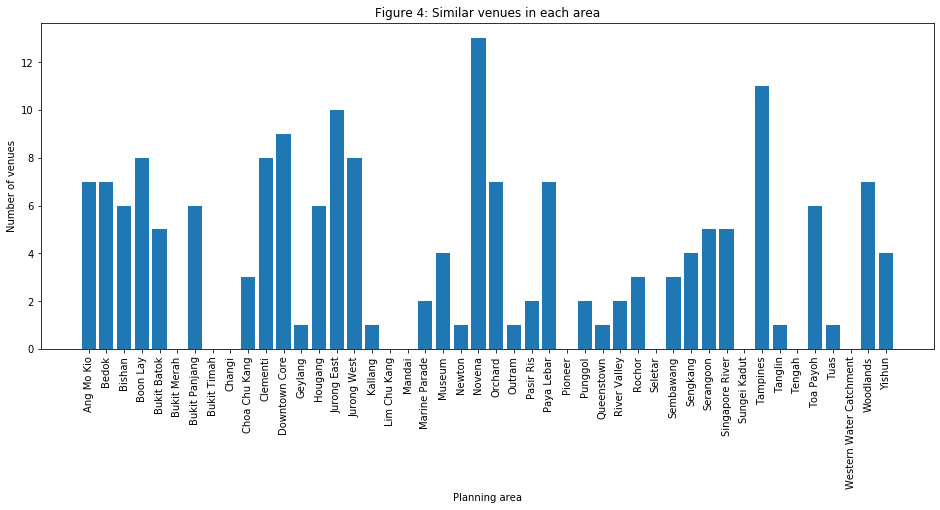

In [22]:
# bar plot for similar venue count for each area
plt.figure(figsize = (16,6))
plt.bar(df.index, df['sim_venue'])
plt.title('Figure 4: Similar venues in each area')
plt.ylabel('Number of venues')
plt.xlabel('Planning area')
plt.xticks( rotation = 90)
plt.show()

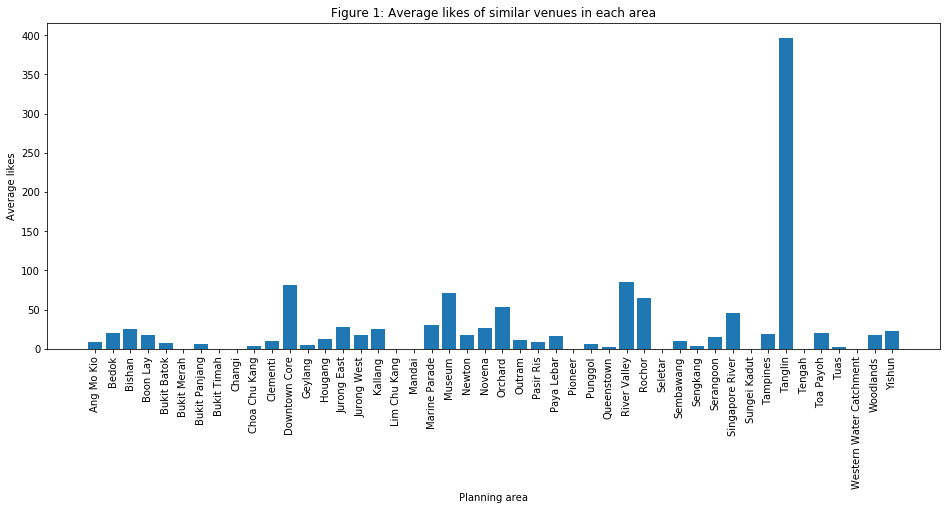

In [23]:
# bar plot for average likes for each area

plt.figure(figsize = (16,6))
plt.bar( df.index, df['avg_likes'])
plt.title('Figure 1: Average likes of similar venues in each area')
plt.ylabel('Average likes')
plt.xlabel('Planning area')
plt.xticks( rotation = 90)
plt.show()

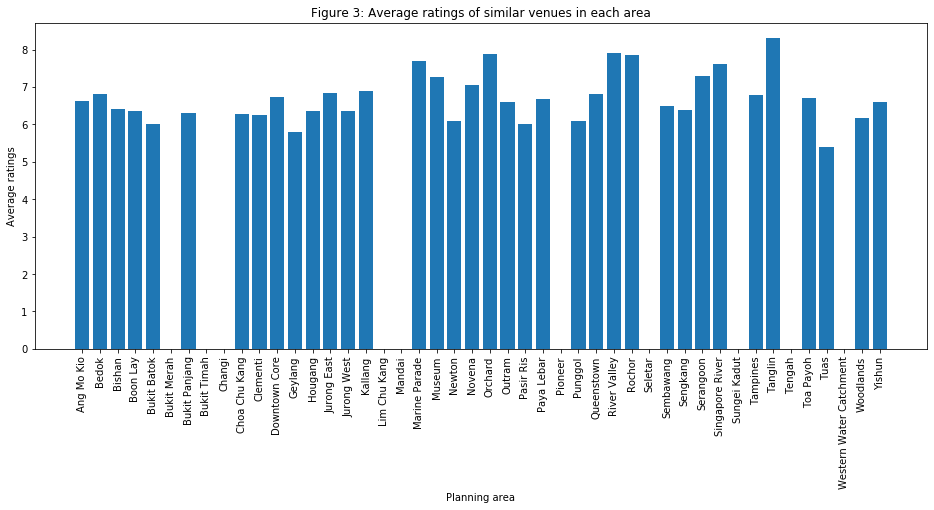

In [24]:
# bar plot for average ratings for each area

plt.figure(figsize = (16,6))
plt.bar(df.index, df['avg_ratings'])
plt.title('Figure 3: Average ratings of similar venues in each area')
plt.ylabel('Average ratings')
plt.xlabel('Planning area')
plt.xticks( rotation = 90)
plt.show()

In [25]:
# finding all the venues in Tanglin
for index in df_venue2.index:
    if df_venue2.loc[index,'Area'] == 'Tanglin':
        print(index)

1531


In [26]:
df_venue.loc[1531]

Area                          Tanglin
Area_lat                      1.30604
Area_lng                      103.815
Venue                         PS.Cafe
Venue_lat                     1.30457
Venue_lng                     103.811
Category                         Café
venue_id     4b08ac7df964a520951023e3
Name: 1531, dtype: object

Tanglin has only 1 similar venue and may potentially be an oulier with such a higher number of Average likes.
The cafe is PS cafe, a highly popular cafe explaining the high amount of likes

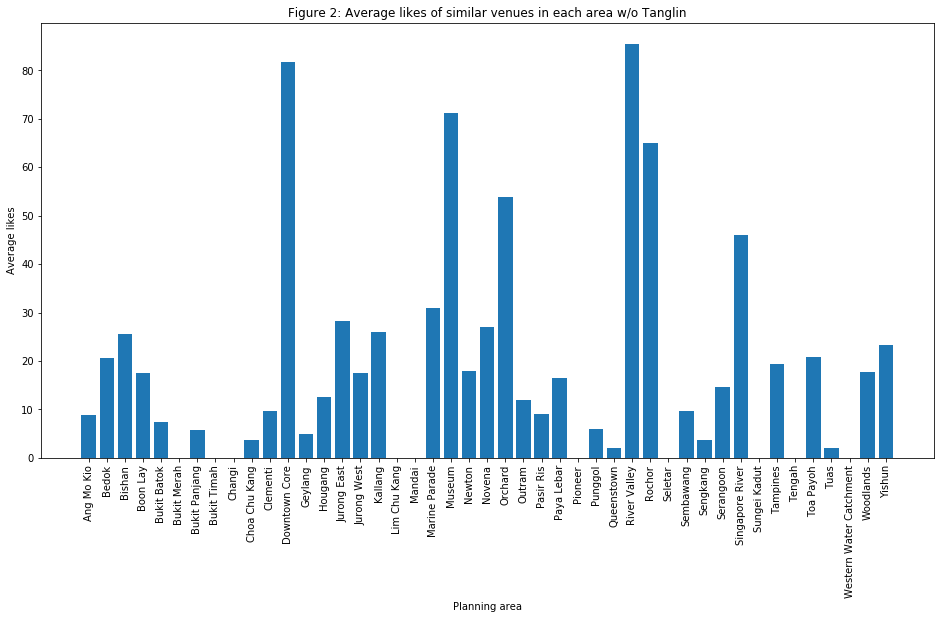

In [27]:
# average likes without Tanglin for better understanding of average likes among the rest of the areas
df2 = df.drop('Tanglin')

plt.figure(figsize = (16,8))
plt.bar( df2.index, df2['avg_likes'])
plt.title('Figure 2: Average likes of similar venues in each area w/o Tanglin')
plt.ylabel('Average likes')
plt.xlabel('Planning area')
plt.xticks( rotation = 90)

plt.show()

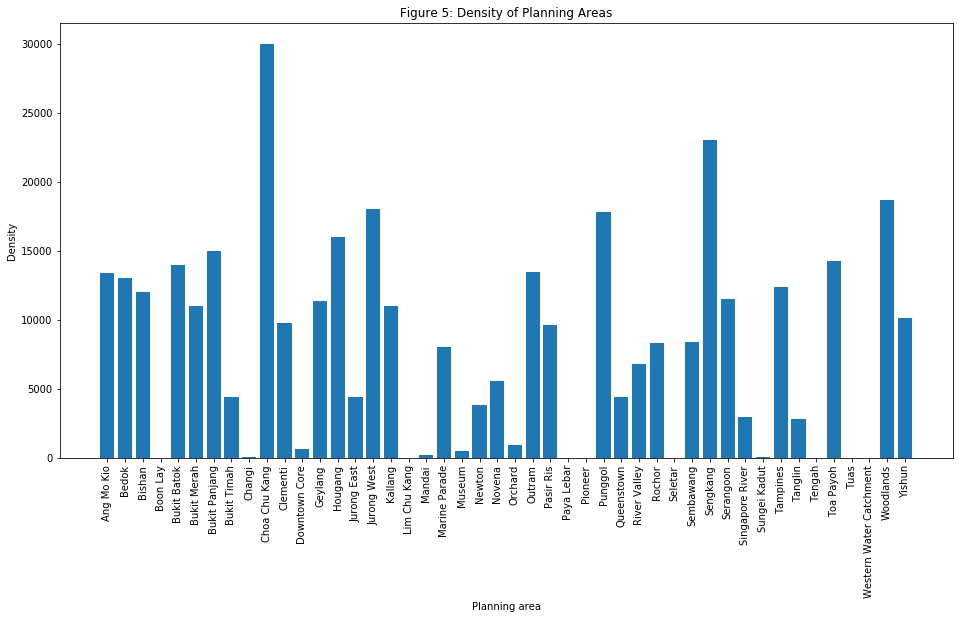

In [30]:
# bar plot for population density for each area

plt.figure(figsize = (16,8))
plt.bar( df.index, df['Density'])
plt.title('Figure 5: Density of Planning Areas')
plt.ylabel('Density')
plt.xlabel('Planning area')
plt.xticks( rotation = 90)
plt.show()

In [31]:
# create map
map_clusters = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, avg_likes , avg_ratings, Density in zip(df['latitude'], df['longitude'], df.index, df['Cluster Labels'], df['avg_likes'], df['avg_ratings'], df['Density']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster) 
                        + '<br> Average likes: ' + str(avg_likes)
                        + '<br> Average rating: ' + str(avg_ratings)
                        + '<br> Density: ' + str(Density))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters